In [1]:
import warnings
import matplotlib.pyplot as plt
import ngflowboost as ngbf
import numpy as np
import torch

from models.flow import build_model

warnings.filterwarnings('ignore')

In [2]:
def _generate_data(n=100, std=0.1):
    eps = std * np.random.randn(n)
    x = np.random.rand(n) * 2*np.pi
    y = np.sin(x) + eps
    return x, y


def generate_data(n=100, std=0.1):
    x1, y1 = _generate_data(n=n, std=std)
    x2, y2 = _generate_data(n=n, std=std)
    y2 = -y2
    return np.concatenate([x1, x2]).reshape(-1, 1), np.concatenate([y1, y2])

In [3]:
x, y = generate_data(n=100, std=0.05)

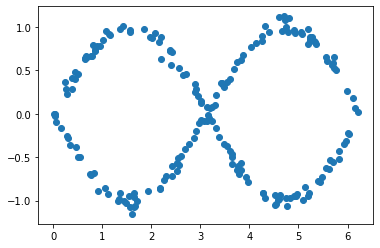

In [4]:
plt.scatter(x, y)
plt.show()

In [5]:
flow = build_model(
    input_dim=1,
    hidden_dims=(40,40,40,),
    context_dim=0,
    conditional=False,
    time_length=1.0,
    batch_norm=True,
    layer_type="concatscale"
)

model = ngbf.NGBoost(verbose_eval=25, flow=flow, flow_init_iters=100)

In [6]:
model.fit(x, y)

Loss 0.75: 100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


[iter 0] loss=0.7219 val_loss=0.0000 scale=512.0000 norm=1.2069
[iter 25] loss=0.6664 val_loss=0.0000 scale=256.0000 norm=0.7042
[iter 50] loss=0.8641 val_loss=0.0000 scale=128.0000 norm=0.3914
[iter 75] loss=0.7389 val_loss=0.0000 scale=128.0000 norm=0.3932
[iter 100] loss=0.5205 val_loss=0.0000 scale=128.0000 norm=0.3880
[iter 125] loss=0.6688 val_loss=0.0000 scale=64.0000 norm=0.2108
[iter 150] loss=0.4877 val_loss=0.0000 scale=32.0000 norm=0.1083
[iter 175] loss=0.5725 val_loss=0.0000 scale=32.0000 norm=0.1070
[iter 200] loss=0.8194 val_loss=0.0000 scale=64.0000 norm=0.2023
[iter 225] loss=0.5226 val_loss=0.0000 scale=32.0000 norm=0.1061
[iter 250] loss=0.6562 val_loss=0.0000 scale=64.0000 norm=0.2101
[iter 275] loss=0.5810 val_loss=0.0000 scale=32.0000 norm=0.1065
[iter 300] loss=0.5400 val_loss=0.0000 scale=0.0312 norm=0.0001
[iter 325] loss=0.6244 val_loss=0.0000 scale=64.0000 norm=0.2199
[iter 350] loss=0.6995 val_loss=0.0000 scale=0.0625 norm=0.0002
[iter 375] loss=0.6822 val_

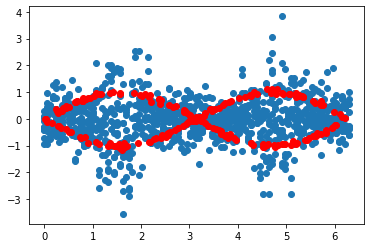

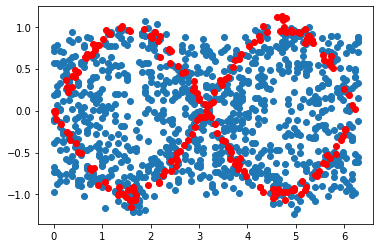

In [7]:
DEVICE = model.DEVICE
n_samples = 10

# x, y = generate_data(std=0.01)

x_new = torch.linspace(0, 2*np.pi, 101).repeat(n_samples).reshape(-1, 1)
y_params = model.pred_param(x_new)
y_samples = model.pred_dist(x_new).sample(1)

# plt.errorbar(x_new, y_params[:, 0], yerr=np.exp(y_params[:, 1]), fmt='o')
plt.scatter(x_new, y_samples)
plt.scatter(x, y, c='red')
plt.show()

x_new = x_new.to(DEVICE)
y_params = torch.Tensor(y_params).to(DEVICE)
z = torch.randn(len(x_new), 1).to(DEVICE)
z = (z + y_params[:, 0].reshape(-1, 1)) * y_params[:, 1].exp().reshape(-1, 1)

y_new = model.flow(x=z, context=x_new, reverse=True)
y_new = y_new.detach().cpu().numpy()

plt.scatter(x_new.detach().cpu().numpy(), y_new)
plt.scatter(x, y, c='red')
plt.show()